NOTEBOOK SET UP

In [17]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


IMPORTS

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from data import DATA_DIR
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from datetime import datetime

LOADING DATA

In [19]:
stocks = pd.read_csv(
    DATA_DIR +  '/NVDA.csv', 
    dtype={
        "Date": "period[D]",
        "Open": "float32",
        "High": "float32",
        "Low": "float32",
        "Close": "float32",
        "Volume": "int32",
        "Adj close": "float32",
    },
    index_col="Date"
).sort_index(ascending=True)
stocks.columns = stocks.columns.str.lower()

events_presentation = pd.read_csv(
    DATA_DIR + "/events_presentation.csv",
    dtype={
        "date": "period[D]",
        "name": "string",
    },
    index_col="date",
).sort_index(ascending=True)

events_corporate = pd.read_csv(
    DATA_DIR + "/events_corporate.csv",
    dtype={"start_date": "period[D]", "end_date": "period[D]", "name": "string", "location": "string"},
    index_col="start_date",
).sort_index(ascending=True)


display(stocks.head())
display(events_presentation.head())
display(events_corporate.head())

,open,high,low,close,adj close,volume
Date,,,,,,
1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376237,271468800
1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415653,51048000
1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383404,34320000
1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382209,24436800
1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381015,22752000


,name
date,
2018-01-07,NVIDIA 2018 CES Press Conference with CEO Jens...
2018-01-09,16th Annual JP Morgan CES Tech Forum
2018-01-10,Citi 2018 TMT West Conference
2018-02-08,NVIDIA 4th Quarter FY18 Financial Results
2018-02-13,Goldman Sachs Technology and Internet Conference


,end_date,name,location
start_date,,,
2019-10-05,2019-10-06,ACR Imaging Informatics Summit,Ronald Reagan Building and International Trade...
2019-10-13,2019-10-17,MICCAI,InterContinental Shenzhen / Shenzhen China
2019-10-15,2019-10-19,ASHG,Booth #1447 / George R. Brown Convention Cente...
2019-10-16,NaT,Facebook @Scale,San Jose Convention Center / San Jose CA
2019-10-18,2019-10-20,PDXCON 2019,Funkhaus Berlin / Berlin Germany


UTILITIES

In [20]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette(
        "husl",
        n_colors=X[period].nunique(),
    )
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )

    return ax


def plot_periodogram(ts, detrend="linear", ax=None):
    from scipy.signal import periodogram

    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling="spectrum",
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


# From Lesson 4
def lagplot(x, y=None, shift=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText

    x_ = x.shift(shift)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(
        color="C3",
    )
    ax = sns.regplot(x=x_, y=y_, scatter_kws=scatter_kws, line_kws=line_kws, lowess=True, ax=ax, **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    title = f"Lag {shift}" if shift > 0 else f"Lead {shift}"
    ax.set(title=f"Lag {shift}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, leads=None, nrows=1, lagplot_kwargs={}, **kwargs):
    import math

    kwargs.setdefault("nrows", nrows)
    orig = leads is not None
    leads = leads or 0
    kwargs.setdefault("ncols", math.ceil((lags + orig + leads) / nrows))
    kwargs.setdefault("figsize", (kwargs["ncols"] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs["nrows"] * kwargs["ncols"])):
        k -= leads + orig
        if k + 1 <= lags:
            ax = lagplot(x, y, shift=k + 1, ax=ax, **lagplot_kwargs)
            title = f"Lag {k + 1}" if k + 1 >= 0 else f"Lead {-k - 1}"
            ax.set_title(title, fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis("off")
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

VISUALISATION - TREND



<Axes: xlabel='Date', ylabel='Close Price'>

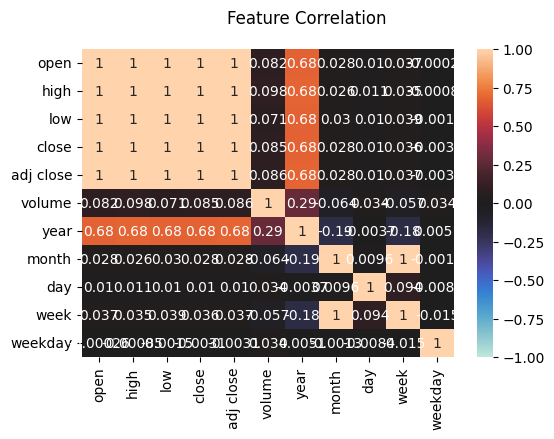

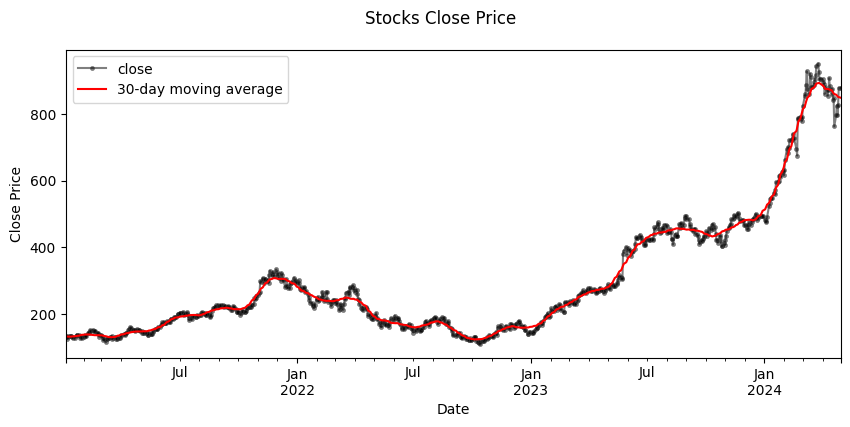

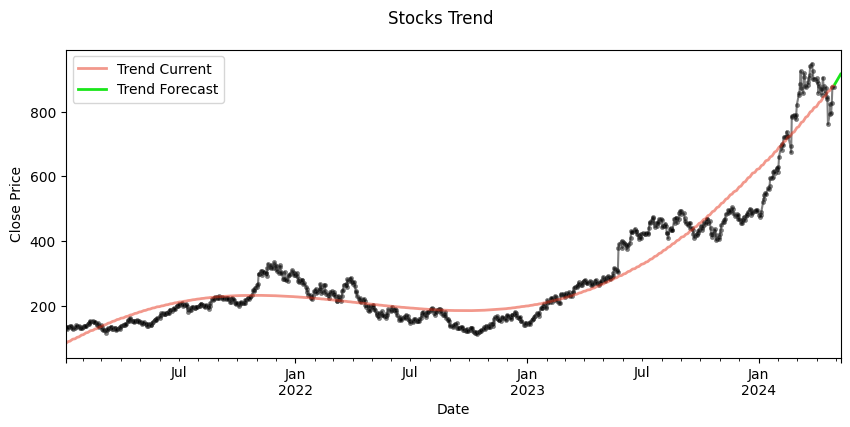

In [21]:
# --- SETUP ---
MOVING_AVERGE_WINDOW = 30
STOCK_RECENT_YEARS = 3


sns.set_palette(palette="pastel")
stock = stocks[f"{datetime.now().year - STOCK_RECENT_YEARS}":]
stock.loc[:,["year"]] = stock.index.year # type: ignore
stock.loc[:,["month"]] = stock.index.month  # type: ignore
stock.loc[:,["day"]] = stock.index.day  # type: ignore
stock.loc[:,["week"]] = stock.index.week  # type: ignore
stock.loc[:,["weekday"]] = stock.index.weekday  # type: ignore
stock_close = stock["close"]


# --- EXPLORATION ---

# HEATMAP
fig1 = plt.figure(figsize=(6, 4))
fig1.suptitle("Feature Correlation")
sns.heatmap(stock.corr(method="spearman"), vmin=-1, vmax=1, center=0, annot=True)


# STOCK
fig2 = plt.figure(figsize=(10, 4))
fig2.suptitle("Stocks Close Price")
stock_close.plot(style=".-", ax=fig2.gca(), color="black", alpha=0.5, markeredgecolor="0.25", markeredgewidth=0.5, legend=True, ylabel="Close Price")
moving_average = stock_close.rolling(window=MOVING_AVERGE_WINDOW, center=True, min_periods=MOVING_AVERGE_WINDOW//2).mean()
moving_average.plot(style="-", color="red", ax=fig2.gca(), label=f"{MOVING_AVERGE_WINDOW}-day moving average", legend=True)

# TREND
TREND_ORDER = 5
dp = DeterministicProcess(index=stock_close.index, constant=True, order=TREND_ORDER, drop=True)
X_dp_in = dp.in_sample()
X_dp_fore = dp.out_of_sample(steps=10)

trend_model = LinearRegression(fit_intercept=False)
trend_model.fit(X_dp_in, stock_close)

y_dp_pred = pd.Series(trend_model.predict(X_dp_in), index=X_dp_in.index)
y_dp_fore = pd.Series(trend_model.predict(X_dp_fore), index=X_dp_fore.index)

fig3 = plt.figure(figsize=(10, 4))
fig3.suptitle("Stocks Trend")

stock_close.plot(style=".-", ax=fig3.gca(), color="black", alpha=0.5, markeredgecolor="0.25", markeredgewidth=0.5, ylabel="Close Price")
y_dp_pred.plot(style="-",linewidth=2, color=(0.9, 0.2, 0.1, 0.5), ax=fig3.gca(), label="Trend Current", legend=True)
y_dp_fore.plot(style="-",linewidth=2, color=(0.1, 0.9, 0.1, 1), ax=fig3.gca(), label="Trend Forecast", legend=True)

VISUALISATION - SEASONALITY

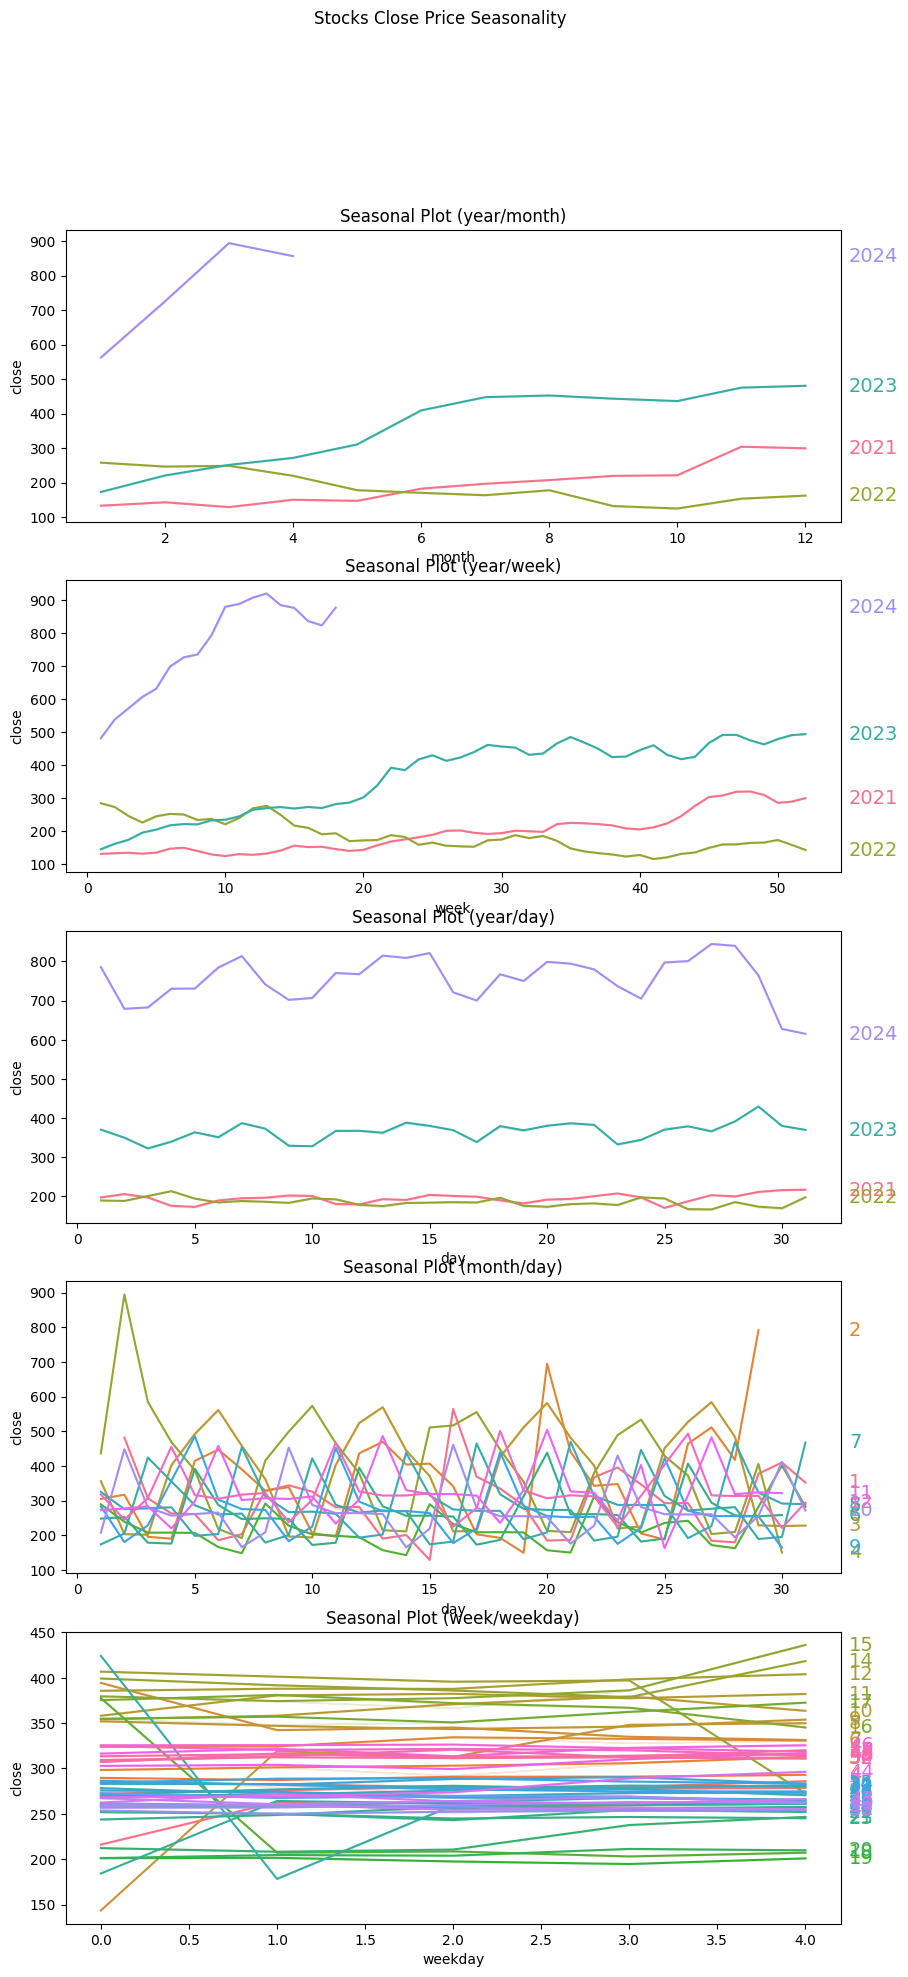

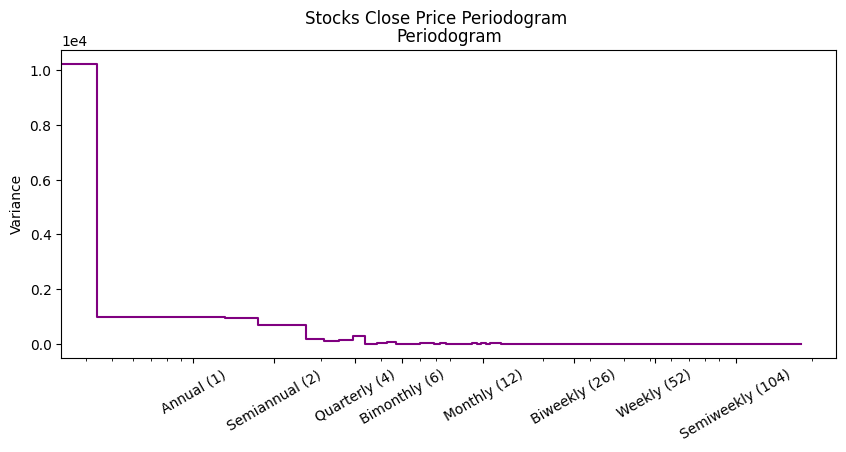

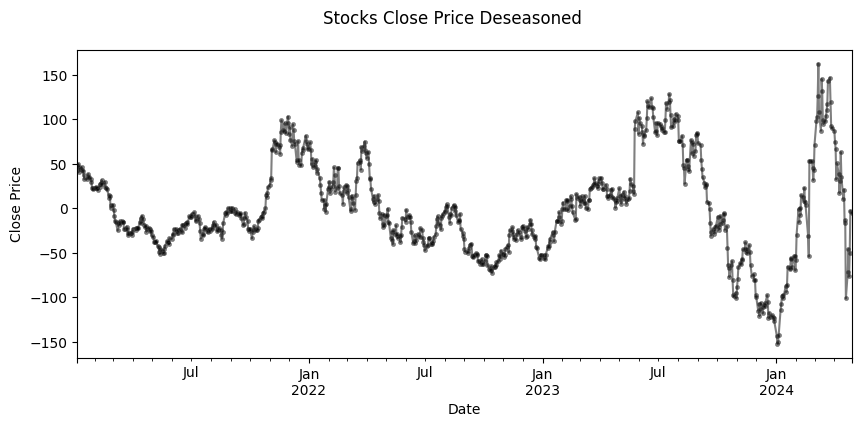

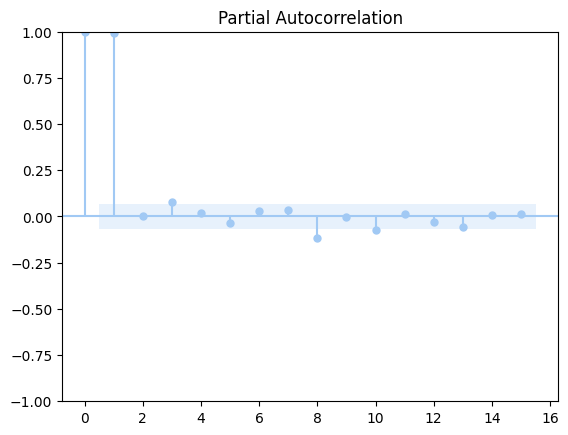

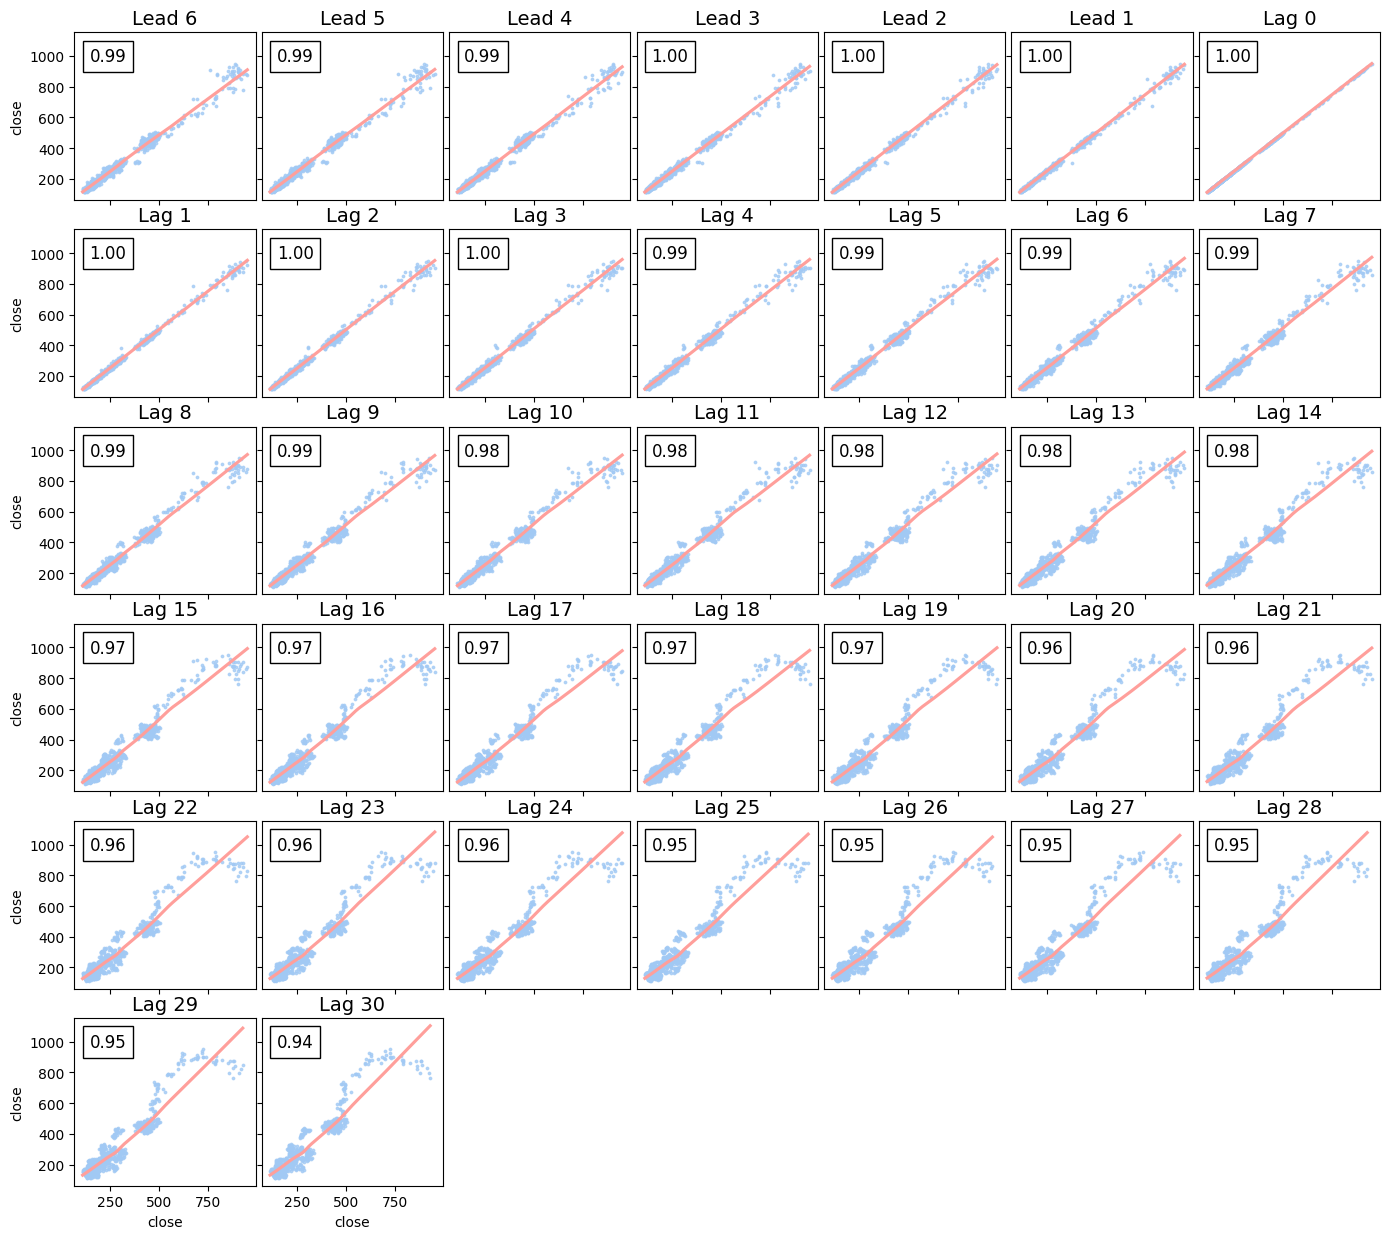

In [22]:
# SEASONALITY
fig4, (ax40, ax41, ax42, ax43, ax44) = plt.subplots(5, 1,  figsize=(10, 22))
fig4.suptitle("Stocks Close Price Seasonality")
seasonal_plot(stock, "close", "year", "month", ax=ax40)
seasonal_plot(stock, "close", "year", "week", ax=ax41)
seasonal_plot(stock, "close", "year", "day", ax=ax42)
seasonal_plot(stock, "close", "month", "day", ax=ax43)
seasonal_plot(stock, "close", "week", "weekday", ax=ax44)

# PERIODOGRAM
fig5, ax50 = plt.subplots(1, 1, figsize=(10, 4))
fig5.suptitle("Stocks Close Price Periodogram")
plot_periodogram(stock_close, ax=ax50)


# DEASEASONED
fig6 = plt.figure(figsize=(10, 4))
y_dp_deseasoned = stock_close  - y_dp_pred
fig6.suptitle("Stocks Close Price Deseasoned")
y_dp_deseasoned.plot(style=".-", ax=fig6.gca(), color="black", alpha=0.5, markeredgecolor="0.25", markeredgewidth=0.5, ylabel="Close Price")

# # DEASEASONED PERIODOGRAM
# fig7 ,rest = plt.subplots(1, 1, figsize=(10, 4))
# plot_periodogram(y_dp_deseasoned, ax=fig7.gca())

# # PARTIAL AUTOCORRELATION
fig8 = plot_pacf(x=stock_close, ax=None, lags=15, title="Partial Autocorrelation", alpha=0.05)

# # LAG PLOTS
fig9 = plot_lags(x=stock_close, y=stock_close, lags=30, leads=6, nrows=6)

OBSERVATIONS FOR NVIDIA
- There is a positive trend
- There is a weak to none seasonality 
- There are cycles
- There are outliers

EVENTS

<Axes: xlabel='Date', ylabel='Event corporate'>

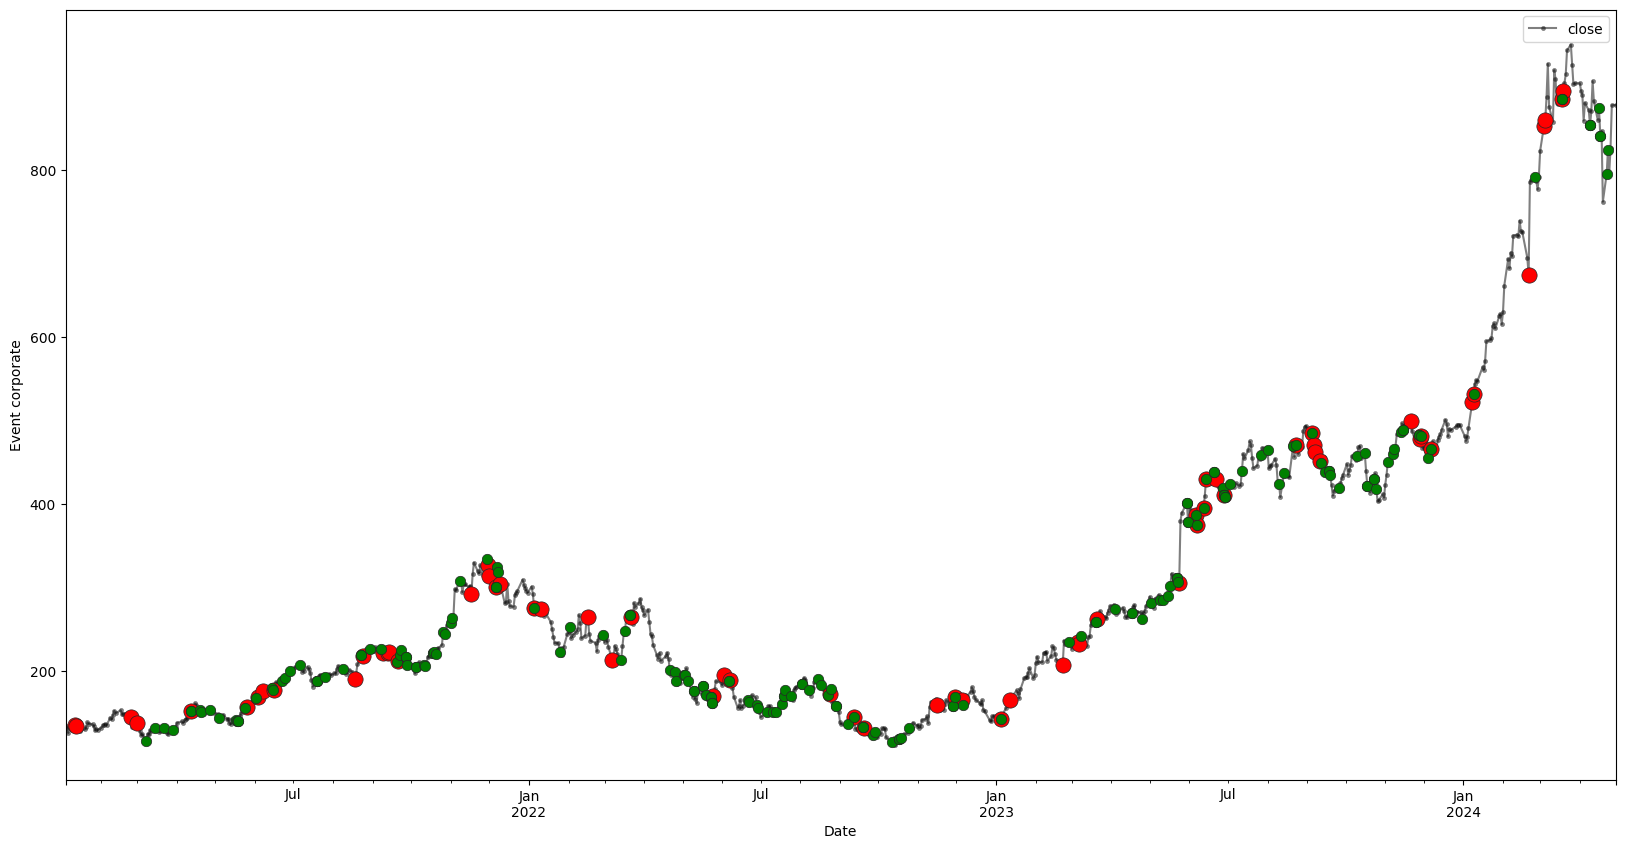

In [23]:
fig_1 = plt.figure(figsize=(20,10))

stock_close.plot(
    style=".-",
    ax=fig_1.gca(),
    color="black",
    alpha=0.5,
    markeredgecolor="0.25",
    markeredgewidth=0.5,
    ylabel="Close Price",
    legend=True,
)

events_recent_presentation = events_presentation[f"{datetime.now().year - STOCK_RECENT_YEARS}":]
events_recent_corporate = events_corporate[f"{datetime.now().year - STOCK_RECENT_YEARS}":]

events_presentation.join(stock_close, how="inner")["close"].plot(
    style=".",
    color="red",
    markersize=22,
    markeredgecolor="0.15",
    markeredgewidth=0.5,
    ylabel="Event presentation",
    ax=fig_1.gca(),
)


events_recent_corporate.join(stock_close, how="inner")["close"].plot(
    style=".",
    color="green",
    markersize=15,
    markeredgecolor="0.15",
    markeredgewidth=0.5,
    ylabel="Event corporate",
    ax=fig_1.gca(), 
)


OBSERVATIONS:
- Events do not contribute much to the sales

/tmp/ipykernel_32020/3942164370.py:1: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  stock_week = stock_close.resample("W").mean()


<Axes: xlabel='Date', ylabel='Close Price (Weekly)'>

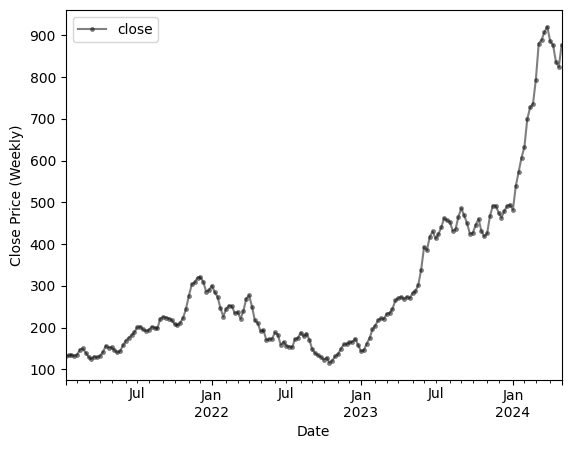

In [24]:
stock_week = stock_close.resample("W").mean()

stock_week.plot(
    style=".-",
    color="black",
    alpha=0.5,
    markeredgecolor="0.25",
    markeredgewidth=0.5,
    ylabel="Close Price (Weekly)",
    legend=True,
)
